In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image

Analyzing Data


In [2]:
train_data=pd.read_csv("fashion-mnist_train.csv")
test_data=pd.read_csv('fashion-mnist_test.csv')

print(train_data.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         

In [3]:
labels=['T-shirt/top'
,'Trouser'
,'Pullover'
,'Dress'
,'Coat'
,'Sandal'
,'Shirt'
,'Sneaker'
,'Bag'
,'Ankle boot']

In [4]:
y_train=train_data['label']
train_data=train_data.drop('label',axis='columns')

y_test=test_data['label']
test_data=test_data.drop('label',axis='columns')


In [5]:
print(train_data.shape)

(60000, 784)


In [6]:
X_train=np.array(train_data).astype('float32')
X_test=np.array(test_data).astype('float32')

In [7]:
train_images=X_train.reshape(60000,28,28)
test_images=X_test.reshape(10000,28,28)

train_images=train_images/255.
test_images=test_images/255.

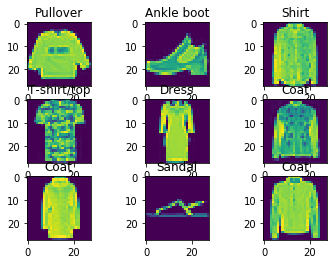

In [8]:
for i in range(9):
    plt.subplot(3,3,(i+1))
    plt.imshow(train_images[i][:,:])
    plt.title(labels[y_train[i]])
    

In [9]:
# Creating Dataset for pytorch model

In [10]:
class FashionDataset(Dataset):
    def __init__(self,source,transform=None):
        self.transform=transform
        self.dataset=pd.read_csv(source)
        
        label=[]
        image=[]
        
        for i in list(self.dataset.values):
            label.append(i[0])
            image.append(i[1:])

        self.labels=np.asarray(label)
        self.images=np.asarray(image).reshape(-1,28,28,1).astype('float32')
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self,idx):
        label=self.labels[idx]
        image=self.images[idx]
        if self.transform :
            image=self.transform(image)
        return image,label
          

In [11]:
dataset = FashionDataset("fashion-mnist_train.csv")
dataset.images.shape

(60000, 28, 28, 1)

In [12]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

train_set= FashionDataset("fashion-mnist_train.csv",transform=transform)
test_set=FashionDataset("fashion-mnist_test.csv",transform=transform)

In [13]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpy")
device

device(type='cuda')

In [14]:
trainLoader=DataLoader(train_set,batch_size=100,shuffle=True)
testLoader=DataLoader(test_set,batch_size=100,shuffle=True)


In [15]:
a=next(iter(trainLoader))
print(a[0].size())

torch.Size([100, 1, 28, 28])


In [16]:
classes = ('T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  Sandal, Pullover, Coat, Shirt, T-Shirt, Ankle Boot, Dress, Sneaker, Shirt, Pullover, 

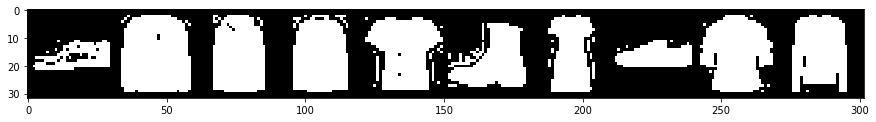

In [17]:
demoloader=DataLoader(train_set,batch_size=10,shuffle=True)
batch= next(iter(demoloader))
images,labels= batch

grid=torchvision.utils.make_grid(images,nrow=10)
plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(classes[label], end=", ")


In [18]:
# Defining the Model

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.cnn=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(32,64,kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.Fc=nn.Sequential(
        nn.Linear(64*6*6,600),
        nn.Dropout2d(0.25),
        nn.ReLU(),
        nn.Linear(600,120),
        nn.ReLU(),
        nn.Linear(120,10)
        )
        
    def forward(self,x):
        x=self.cnn(x)
        x=x.view(x.size(0),-1)
        x=self.Fc(x)
        return x

In [19]:
model=Net()
model.to(device)

Net(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Fc): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): Dropout2d(p=0.25, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=120, bias=True)
    (4): ReLU()
    (5): Linear(in_features=120, out_features=10, bias=True)
  )
)

In [20]:
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)


In [21]:
def evaluate(model,dataloader):
    total=0
    correct=0
    model.eval()
    for data in dataloader:
        inputs,labels=data
        inputs,labels=inputs.to(device),labels.to(device)
        inputs=Variable(inputs.view(100,1,28,28))
        labels=Variable(labels)
        outputs=model(inputs)
        topi= torch.max(outputs.data,1)[1]
        total+=len(labels)
        correct+=(topi==labels).sum()
        
    return 100*correct / total

In [22]:

losses=[]
loss_epoch=[]
epochs=10
count=0
iteration_list=[]
accuracy_list=[]

for epoch in range(epochs):
    for data in trainLoader:

        model.train()
        inputs,labels=data
        inputs=inputs.to(device)
        labels=labels.to(device)

        inputs=Variable(inputs.view(100,1,28,28))
        labels=Variable(labels)


        outputs=model(inputs)
        optimizer.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()

        optimizer.step()
        count+=1
        if not count%50:
            accuracy=evaluate(model,testLoader)
            losses.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)


        if not count%500:
        
            print("Iteration {}  Train Loss {}, Accracy :{} ".format(count,loss.item(),accuracy))
    
            torch.save(model ,'fashion_mnist.pt')



            
            
    

..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Iteration 500  Train Loss 0.34235459566116333, Accracy :88 


C:\Users\Jatin\Anaconda3\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Iteration 1000  Train Loss 0.2771851420402527, Accracy :90 
Iteration 1500  Train Loss 0.26870405673980713, Accracy :90 
Iteration 2000  Train Loss 0.24487602710723877, Accracy :91 
Iteration 2500  Train Loss 0.09908922016620636, Accracy :92 
Iteration 3000  Train Loss 0.24100810289382935, Accracy :92 


In [24]:
model=torch.load('fashion_mnist.pt')
print('Test acc: %0.2f, Train acc: %0.2f' % (evaluate(model,testLoader), evaluate(model,trainLoader)))


Test acc: 92.00, Train acc: 94.00


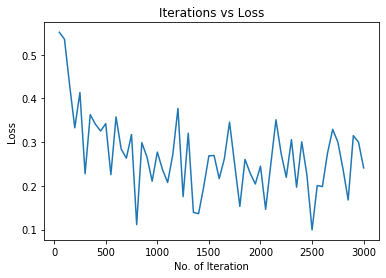

In [26]:
plt.plot(iteration_list,losses)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

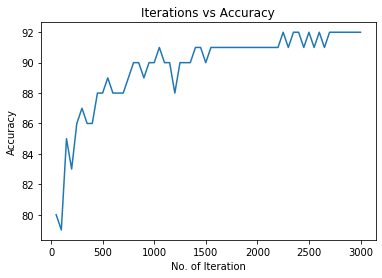

In [27]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()